In [143]:
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# import project_MC_Ising_STRidge as sRid

In [2]:
tsteps = 1024

In [3]:
file_path = "C:\\Users\\Ryan\\Documents\\Github\\Masters_Vogt_AMATH563_Final\\Generated\\"
save_path = "C:\\Users\\Ryan\\Documents\\Github\\Masters_Vogt_AMATH563_Final\\Processed\\"

# Import Data

In [ ]:
def load_config(file_path, grid_size, sample, broad = False):
    if broad:
        file = open(file_path+"Ising_broad_"+str(grid_size)+"_"+str(sample)+".pickle", 'rb')
    else:
        file = open(file_path+"Ising"+str(grid_size)+"_"+str(sample)+".pickle", 'rb')
    return pickle.load(file)

# Calculate SVDs

In [ ]:
def calc_svds(file_path, size, broad=False):
    sing_list = []
    u_list = []
    v_list = []
    temps = load_config(file_path, size, 1, broad = broad)['Temperature']

    for i in range(10):
        sings = np.zeros([size*size, 0])
        us = []
        vs = []
        sample = load_config(file_path, size, i+1, broad)
        for data in tqdm(sample['State']):
            u ,s,v = np.linalg.svd(data)
            sings = np.append(sings, np.expand_dims(s,-1), axis = 1)
            us.append(u)
            vs.append(v)
        sing_list.append(sings)
        u_list.append(us)
        v_list.append(vs)
    return u_list, sing_list, v_list, temps

In [ ]:
fig = plt.figure(figsize =(15,10))
ax1 = plt.subplot(121, projection = '3d')
x = temps
y = np.linspace(1, tsteps, tsteps)
X,Y = np.meshgrid(x,y)
z1 = np.array(u_list[0])[:,0, :]
ax1.plot_surface(X, Y, z1.T, edgecolor='none', cmap='viridis')
plt.xlabel('Temperature')
plt.ylabel('Time')
plt.title('Mode 1')
ax1.view_init(30,45)

# ax2 = plt.axes(projection = '3d')
ax2 = plt.subplot(122, projection = '3d')
z2 = np.array(u_list[0])[:,1, :]
ax2.plot_surface(X, Y, z2.T, edgecolor='none', cmap='viridis')
plt.xlabel('Temperature')
plt.ylabel('Time')
plt.title('Mode 2')
ax2.view_init(30,45)

## Generate average SV matrices

In [ ]:
broad = True
size = 8

In [ ]:
def save_avgs(file_path, save_path, size, broad=True):
    u_list, sing_list, v_list, temps = calc_svds(file_path, size, broad)
    smsum = np.zeros([size*size, len(temps)])
    for sm in sing_list:
        smsum = smsum + sm
    smsum = smsum/len(sing_list)
    np.save(open(save_path+ 'SVavg_'+str(size), 'wb'), smsum.T)    

In [ ]:
save_avgs(file_path, save_path, size, broad)

In [ ]:
fig = plt.figure(figsize =(12,12))
ax = plt.axes(projection = '3d')
x = temps[1:-1]
y = np.linspace(1, size**2, size**2)
X,Y = np.meshgrid(x,y)
ax.plot_surface(X, Y, fder.T, edgecolor='none', cmap='viridis', shade = True)
plt.xlabel('Temperature')
plt.ylabel('Singular value number')
ax.view_init(10,75)

## Build Library

In [4]:
data = np.load(save_path+'SVavg_16').astype(np.float64)
temps = np.load(save_path+'broad_temps.npy')

In [5]:
from scipy.sparse import diags
def calc_dyn(data, h):
    length = data.shape[0] 
    A = 1 / (2 * h) * diags([-1, 0, 1], [-1, 0, 1], shape=(length, length)).todense()
    dynamics = np.matmul(A, data[:,:])[1:-1, :] # neglect first and last entry per temperature axis to avoid boundary conflicts with cetnral differencing
    return dynamics

In [121]:
dT = temps[1]-temps[0]
dyn_test = calc_dyn(data, dT)
dyn_test.shape
dyn_test_c = dyn_test[:,1:]
dyn_test_c.shape

(198, 255)

In [122]:
flat_dyn = np.ravel(dyn_test_c)

In [158]:
def build_library(dyn, temps, degree=3):
    t = [np.array(temps[1:-1])]
    ts = np.repeat(t, np.shape(dyn)[1], axis = 0).T
    dyn = np.ravel(dyn)
    ts = ts.flatten()
    library = np.zeros([len(ts), 0])
    key_list = np.zeros((0,2))
    for i in range(degree+1):
        for j in range(i+1):
            library = np.append(library, np.expand_dims((dyn**j)*(ts**(i-j)), -1), axis = 1)
            key_list= np.append(key_list, [[j, i-j]], axis=0)
    return library, key_list

In [160]:
test_lib, keys= build_library(dyn_test_c, temps, 6)
test_lib = test_lib.astype(np.float64)
norm_lib= test_lib / test_lib.sum(axis=0, keepdims = True)

In [139]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

def STRidge(library, dynamics, alpha, tol, iters=10): 
#     if iters % 5 ==0:
#         print('Iters= '+str(iters))
    lib_ind = list(range(library.shape[1])) #Track index of functions kept
    thresh = tol * np.ones(library.shape[0])
    reg = linear_model.Ridge(alpha=alpha)  # regress
    mod = reg.fit(library,dynamics)
    xi = mod.coef_
    big_coefs = np.greater(np.abs(xi), tol)
    xi[~big_coefs] = 0
    if iters > 0 and len(xi[big_coefs])>0 :
        xi[big_coefs] = STRidge(library[:,big_coefs], dynamics, alpha, tol, iters-1)
    return xi
        
#         for j in range(len(lib_ind)):
#             print("j = "+str(j))
#             if xi[j] < tol:  # threshold out small coefficients
#                 xi[j] = 0

#     return xi, lib_ind, library


def PDE_Find(library, dynamics, d_tol, tol_iters, ridge_iters=10):
  
    lib_train, lib_test, dynam_train, dynam_test = train_test_split(library, dynamics, test_size=1/5)
    xi_best = np.zeros(lib_test.shape[1])
    alpha = 1e-3 * np.linalg.cond(library)
    
    error_best = np.linalg.norm(np.matmul(lib_test, xi_best) - dynam_test, 2)**2 + alpha*np.linalg.norm(xi_best,0)
    tol = d_tol
    

    for iters in range(tol_iters):
        xi = STRidge(library=lib_train, dynamics=dynam_train, alpha=alpha, tol=tol, iters=ridge_iters)
        error = np.linalg.norm(np.matmul(lib_test, xi) - dynam_test)**2 + alpha * np.linalg.norm(xi,0)
        if iters % 25 == 0:
            print('Error= ' +str(error)+', Iteration '+str(iters))
        if error <= error:
            xi_best = xi
            error_best = error
            tol += d_tol
        else:
            tol = max([0, tol - 2 * d_tol])
            d_tol = 2 * d_tol / (tol_iters - iter)
            tol += d_tol
    return xi_best, error_best


In [140]:
xi_best, error_best = PDE_Find(norm_lib, flat_dyn, .001, 200, 30)

Error= 9337624.79463918, Iteration 0
Error= 9300056.91252411, Iteration 25
Error= 9294592.78462191, Iteration 50
Error= 9288973.364685476, Iteration 75
Error= 9286159.830623273, Iteration 100
Error= 9283898.386763941, Iteration 125
Error= 9281757.436663263, Iteration 150
Error= 9281757.436663263, Iteration 175


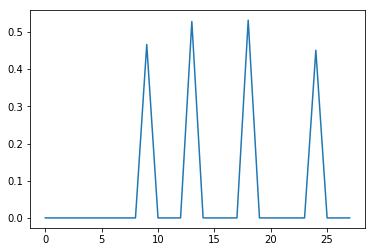

In [141]:
plt.plot(xi_best)

In [142]:
xi_best

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.46629645,
       0.        , 0.        , 0.        , 0.52805886, 0.        ,
       0.        , 0.        , 0.        , 0.53141144, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.45071783,
       0.        , 0.        , 0.        ])

In [110]:
test_lib.sum(axis=0, keepdims = True).shape

(1, 15)

In [111]:
norm_lib= test_lib / test_lib.sum(axis=0, keepdims = True)

array([[ 1.97285354e-05,  5.81222985e-07, -7.58739250e-05, ...,
         2.20591023e-08,  1.32537256e-07,  1.05768636e-08],
       [ 1.97285354e-05,  5.81222985e-07,  3.79888925e-04, ...,
         5.52988373e-07, -1.66352841e-05,  6.64680952e-06],
       [ 1.97285354e-05,  5.81222985e-07,  6.25966677e-05, ...,
         1.50143026e-08, -7.44241642e-08,  4.89994900e-09],
       ...,
       [ 1.97285354e-05,  3.88758477e-05,  3.02469489e-06, ...,
         1.56833944e-07, -5.61619440e-10,  2.67124051e-14],
       [ 1.97285354e-05,  3.88758477e-05,  3.86146682e-06, ...,
         2.55612173e-07, -1.16856893e-09,  7.09571117e-14],
       [ 1.97285354e-05,  3.88758477e-05,  1.10808232e-05, ...,
         2.10484911e-06, -2.76129933e-08,  4.81143696e-12]])

In [ ]:
bar_width = 0.5
for row in keys
labels, c = keys_list[i], coef_list[i]
norm_c = c / np.sum(c)
x_pos = np.arange(len(labels))

fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111)
plt.bar(labels, norm_c, bar_width, color='k', align='center')
plt.ylabel(r'LR Coefficient magnitude', fontsize=12)
plt.xlabel(r'Library functions', fontsize=12)

ax.axhline(y=0, color='k', lw=2)
plt.xticks(rotation='vertical')

# axis and tick params
ax.tick_params(direction='out', length=6, width=4, colors='k',
               grid_color='k', grid_alpha=0.5, labelsize=14)
plt.xticks(x_pos, labels, fontsize=7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)

In [167]:
for row in keys:
    print(row)

[0. 0.]
[0. 1.]
[1. 0.]
[0. 2.]
[1. 1.]
[2. 0.]
[0. 3.]
[1. 2.]
[2. 1.]
[3. 0.]
[0. 4.]
[1. 3.]
[2. 2.]
[3. 1.]
[4. 0.]
[0. 5.]
[1. 4.]
[2. 3.]
[3. 2.]
[4. 1.]
[5. 0.]
[0. 6.]
[1. 5.]
[2. 4.]
[3. 3.]
[4. 2.]
[5. 1.]
[6. 0.]
